# ECE 57000 Assignment 3 Exercise

Your Name:

Prepare the pacakge we will use.

In [1]:
import time
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

## Exercise 0: Train your model on GPU (0 points)

Some tasks in this assignment can take a long time if you run it on the CPU. For example, based on our solution of Exercise 3 Task 4 (Transfer Learning: finetuning of a pretrained model (resnet18)), it will take roughly 2 hours to train the model end-to-end (complete model and not only the last fc layer) for 1 epoch on CPU. Hence, we highly recommend you try to train your model on GPU.

To do so, first you need to enable GPU on Colab (this will restart the runtime). Click `Runtime`-> `Change runtime type` and select the `Hardware accelerator` there.  You can then run the following code to see if the GPU is correctly initialized and available.

**Note**: If you would like to avoid GPU overages on Colab, we would suggest writing and debugging your code before switching on the GPU runtime. Otherwise, the time you spent debugging code will likely count against your GPU usage. Once you have the code running, you can switch on the GPU runtime and train the model much faster.

In [2]:
print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')

Can I can use GPU now? -- True


### You must manually move your model and data to the GPU (and sometimes back to the cpu)
After setting the GPU up on colab, then you should put your **model** and **data** to GPU. We give a simple example below. You can use `to` function for this task. See [torch.Tensor.to](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to move a tensor to the GPU (probably your mini-batch of data in each iteration) or [torch.nn.Module.to](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.to) to move your NN model to GPU (assuming you create subclass [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)). Note that `to()` of tensor returns a NEW tensor while `to` of a NN model will apply this in-place. To be safe, the best semantics are `obj = obj.to(device)`. For printing, you will need to move a tensor back to the CPU via the `cpu()` function.

Once the model and input data are on the GPU, everything else can be done the same.  This is the beauty of PyTorch GPU acceleration.  None of the other code needs to be altered.

To summarize, you need to 1) enable GPU acceleration in Colab, 2) put the model on the GPU, and 3) put the input data (i.e., the batch of samples) onto the GPU using `to()` after it is loaded by the data loaders (usually you only put one batch of data on the GPU at a time).

In [3]:
rand_tensor = torch.rand(5,2) #  creates a 2D tensor (or matrix) with 5 rows and 2 columns, filled with random values uniformly sampled from the range [0, 1). 
simple_model = nn.Sequential(nn.Linear(2,10), nn.ReLU(), nn.Linear(10,1))
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

# device = torch.device('cuda')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----------- <Your code> ---------------
# Move rand_tensor and model onto the GPU device
rand_tensor = rand_tensor.to(device)  
simple_model = simple_model.to(device)  

# --------- <End your code> -------------
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

input is on cpu
model parameters are on [device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]
output is on cpu
input is on cuda:0
model parameters are on [device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0)]
output is on cuda:0


## Exercise 1: Why use a CNN rather than only fully connected layers? (40 points)

In this exercise, you will build two models for the **MNIST** dataset: one uses only fully connected layers and another uses a standard CNN layout (convolution layers everywhere except the last layer is fully connected layer). Note, you will need to use cross entropy loss as your objective function. The two models should be built with roughly the same accuracy performance, your task is to compare the number of network parameters (a huge number of parameters can affect training/testing time, memory requirements, overfitting, etc.).

### Task 1: Prepare train and test function

We will create our train and test procedure in these two functions. The train function should apply one epoch of training. The functions inputs should take everything we need for training and testing and return some logs.

#### Arguments requirement:
* For the `train` function, it takes the `model`, `loss_fn`, `optimizer`, `train_loader`, and `epoch` as arguments.
    * `model`: the classifier, or deep neural network, should be an instance of `nn.Module`.
    * `loss_fn`: the loss function instance. For example, `nn.CrossEntropy()`, or `nn.L1Loss()`, etc.
    * `optimizer`: should be an instance of `torch.optim.Optimizer`. For example, it could be `optim.SGD()` or `optim.Adam()`, etc.
    * `train_loader`: should be an instance of `torch.utils.data.DataLoader`.
    * `epoch`: the current number of epoch. Only used for log printing.(default: 1.) 

* For the `test` function, it takes all the inputs above except for the optimizer (and it takes a test loader instead of a train loader).

#### Log requirement:
Here are some further requirements:
* In the `train` function, print the log 8-10 times per epoch. The print statement should be: 
```python
print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')
```
* In the `test` function, print the log after the testing. The print statement is: 
```python
print(f"Test result on epoch {epoch}: total sample: {total_num}, Avg loss: {test_stat['loss']:.3f}, Acc: {100*test_stat['accuracy']:.3f}%")
```

#### Return requirement 
* The `train` function should return a list, which the element is the loss per batch, i.e., one loss value for every batch.
* The `test` function should return a dictionary with three keys: "loss", "accuracy", and "prediction". The values are the average loss of all the testset, average accuracy of all the test dataset, and the prediction of all test dataset.

#### Other requirement:
* In the `train` function, the model should be updated in-place, i.e., do not copy the model inside `train` function.

In [4]:
def train(model: nn.Module, 
          loss_fn: nn.modules.loss._Loss, 
          optimizer: torch.optim.Optimizer, 
          train_loader: torch.utils.data.DataLoader, 
          epoch: int=0)-> List:
    # ----------- <Your code> ---------------

    # set model to training mode(Gradient calculated, enable dropout, etc)
    model.train()
    train_loss = []

    for batch_idx, (images, targets) in enumerate(train_loader):
        images, targets = images.to(device), targets.to(device) 
        optimizer.zero_grad() # Clear previous gradients
        output = model(images)
        loss = loss_fn(output, targets)
        loss.backward() # Backpropagate
        optimizer.step() # Update weights

        # record train loss and print that out occasionally
        train_loss.append(loss.item())
        if batch_idx % (len(train_loader) // 8) == 0:
            print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')

    # ----------- <End Your code> ---------------
    assert len(train_loss) == len(train_loader)
    return train_loss

def test(model: nn.Module, 
         loss_fn: nn.modules.loss._Loss, 
         test_loader: torch.utils.data.DataLoader, 
         epoch: int=0)-> Dict:
    # ----------- <Your code> ---------------
    
    model.eval() # we need to set the mode for our model

    test_loss = 0
    correct = 0
    predictions = []  # Initialize list to store predictions

    with torch.no_grad():
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device) 
            output = model(images)
            test_loss += loss_fn(output, targets).item()
            pred = output.data.max(1)[1] # we get the estimate of our result by look at the largest class value
            correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples
            predictions.append(pred.cpu().view(-1))  # Flatten and store predictions on CPU

    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    predictions = torch.cat(predictions, dim=0)  


    print(f"Test result on epoch {epoch}: total sample: {len(test_loader.dataset)}, Avg loss: {test_loss:.3f}, Acc: {100 * accuracy:.3f}%")

    # Return stats as a dictionary
    test_stat = {
        "loss": test_loss,
        "accuracy": accuracy,
        "prediction": predictions
    }
    # ----------- <Your code> ---------------
    # dictionary should include loss, accuracy and prediction
    assert "loss" and "accuracy" and "prediction" in test_stat.keys()
    # "prediction" value should be a 1D tensor
    assert len(test_stat["prediction"]) == len(test_loader.dataset)
    assert isinstance(test_stat["prediction"], torch.Tensor)
    return test_stat


### Task 2: Following the structure used in the instructions, you should create

*   One network named `OurFC` which should consist with only fully connected layers

  *   You should decide how many layers and how many hidden dimensions you want in your network 
  *   Your final accuracy on the test dataset should lie roughly around 97% ($\pm$2%)
  *   There is no need to make the neural network unnecessarily complex, your total training time should no longer than 3 mins

*   Another network named `OurCNN` which applys a standard CNN structure
  *   Again, you should decide how many layers and how many channels you want for each layer.
  *   Your final accuracy on the test dataset should lie roughly around 97% ($\pm$2%)
  *   A standard CNN structure can be composed as **[Conv2d, MaxPooling, ReLU] x num_conv_layers + FC x num_fc_layers**

* Train and test your network on MNIST data as in the instructions. 
* Notice You can always use the `train` and `test` function you write throughout this assignment.
* The code below will also print out the number of parameters for both neural networks to allow comparison.
* (You can use multiple cells if helpful but make sure to run all of them to receive credit.)


In [5]:
# Download MNIST and transformation
# ----------- <Your code> ---------------

"""
Here the transform is a pipeline containing two seperate transforms: 
1. Transform the data into tensor type
2. Normalize the dataset by a giving mean and std. 
  (Those number is given as the global mean and standard deviation of MNIST dataset)
"""
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.1307,),(0.3081,))])

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

print(train_dataset)

# Print the shape of the image
image, label = train_dataset[0]
print(f"The dimension of the first picture is: {image.shape}")

# ----------- <End Your code> -------------

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
The dimension of the first picture is: torch.Size([1, 28, 28])


In [16]:
# Build OurFC class and OurCNN class.
# ----------- <Your code> ---------------

class OurNN(nn.Module): # Any neural generated network should be generate
  def __init__(self):
    super(OurNN, self).__init__() # calls the parent class (nn.Module) constructor, ensuring that the neural network object is properly initialized.
    # Fully connected layers with increasing complexity
    self.fc0 = nn.Linear(28*28, 4096)  
    self.bn0 = nn.BatchNorm1d(4096)     # THIS IMPACT PERFORMANCE ALOT! Normalizes the inputs across the mini-batch, stabilizing the learning process.
    
    # self.fc1 = nn.Linear(4096, 2048)
    # self.bn1 = nn.BatchNorm1d(2048)   # THIS IMPACT PERFORMANCE ALOT! 
    
    self.fc2 = nn.Linear(4096, 1024)
    self.bn2 = nn.BatchNorm1d(1024)   # THIS IMPACT PERFORMANCE ALOT!
    
    # self.fc3 = nn.Linear(1024, 512)
    # self.bn3 = nn.BatchNorm1d(512)    # THIS IMPACT PERFORMANCE ALOT!
    
    self.fc4 = nn.Linear(1024, 256)
    self.bn4 = nn.BatchNorm1d(256)    # THIS IMPACT PERFORMANCE ALOT!
    
    # self.fc5 = nn.Linear(256, 128)
    # self.bn5 = nn.BatchNorm1d(128)     # THIS IMPACT PERFORMANCE ALOT!
    
    self.fc6 = nn.Linear(256, 10)      
    
    self.dropout = nn.Dropout(p=0.05)   

  def forward(self, x):
    x = x.view(-1, 28*28)  # Flatten the input image
    x = F.relu(self.bn0(self.fc0(x)))  
    x = self.dropout(x)                
    
    # x = F.relu(self.bn1(self.fc1(x))) 
    # x = self.dropout(x)
    
    x = F.relu(self.bn2(self.fc2(x)))  
    x = self.dropout(x)
    
    # x = F.relu(self.bn3(self.fc3(x)))  
    # x = self.dropout(x)
    
    x = F.relu(self.bn4(self.fc4(x)))  
    x = self.dropout(x)
    
    # x = F.relu(self.bn5(self.fc5(x)))  
    # x = self.dropout(x)
    
    x = self.fc6(x)                   
    
    return x


class OurCNN(nn.Module):  
    def __init__(self):
        super(OurCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(3)  # Batch Normalization after conv1
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(3 * 12 * 12, 128)   
        self.bn2 = nn.BatchNorm1d(128)  # Batch Normalization after fc1
        self.fc2 = nn.Linear(128, 10) 

    def forward(self, x):
        x = self.conv1(x)             
        x = self.bn1(x)  # Apply Batch Normalization
        x = F.relu(x)                 
        x = self.pool(x)               
        x = x.view(-1, 3 * 12 * 12)    # Flatten
        x = self.fc1(x)       
        x = self.bn2(x)  # Apply Batch Normalization after fc1
        x = F.relu(x)   
        x = self.fc2(x)                 
        return x

print(OurNN())
print(OurCNN())
# ----------- <End Your code> -------------

OurNN(
  (fc0): Linear(in_features=784, out_features=4096, bias=True)
  (bn0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=1024, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
)
OurCNN(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=432, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128,

In [17]:
from torch.utils.data import DataLoader


# Let's first train the FC model. Below are there common hyperparameters.
criterion = nn.CrossEntropyLoss()

start = time.time()
max_epoch = 3
# ----------- <Your code> ---------------

# Initialize model, optimizer, and criterion
model_fc = OurNN().to(device)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_fc.parameters(), lr=0.01)

# Define data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

for epoch in range(max_epoch):
    train_loss = train(model_fc, criterion, optimizer, train_loader, epoch)
    
    # Evaluate the model after each epoch
    test_stat = test(model_fc, criterion, test_loader, epoch)
    
# ----------- <End Your code> ---------------
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 0: [0/60000] Loss: 2.351
Epoch 0: [7488/60000] Loss: 0.313
Epoch 0: [14976/60000] Loss: 0.151
Epoch 0: [22464/60000] Loss: 0.137
Epoch 0: [29952/60000] Loss: 0.087
Epoch 0: [37440/60000] Loss: 0.118
Epoch 0: [44928/60000] Loss: 0.182
Epoch 0: [52416/60000] Loss: 0.185
Epoch 0: [59904/60000] Loss: 0.070
Test result on epoch 0: total sample: 10000, Avg loss: 0.107, Acc: 96.900%
Epoch 1: [0/60000] Loss: 0.027
Epoch 1: [7488/60000] Loss: 0.150
Epoch 1: [14976/60000] Loss: 0.219
Epoch 1: [22464/60000] Loss: 0.185
Epoch 1: [29952/60000] Loss: 0.095
Epoch 1: [37440/60000] Loss: 0.055
Epoch 1: [44928/60000] Loss: 0.125
Epoch 1: [52416/60000] Loss: 0.038
Epoch 1: [59904/60000] Loss: 0.048
Test result on epoch 1: total sample: 10000, Avg loss: 0.080, Acc: 97.400%
Epoch 2: [0/60000] Loss: 0.107
Epoch 2: [7488/60000] Loss: 0.058
Epoch 2: [14976/60000] Loss: 0.081
Epoch 2: [22464/60000] Loss: 0.030
Epoch 2: [29952/60000] Loss: 0.189
Epoch 2: [37440/60000] Loss: 0.054
Epoch 2: [44928/60000] Lo

In [13]:
# Let's then train the OurCNN model.
start = time.time()
# ----------- <Your code> ---------------
# Initialize model, optimizer, and criterion
model_fc = OurCNN().to(device)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_fc.parameters(), lr=0.001)

# Define data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

for epoch in range(3):
    train_loss = train(model_fc, criterion, optimizer, train_loader, epoch)
    
    # Evaluate the model after each epoch
    test_stat = test(model_fc, criterion, test_loader, epoch)

# ----------- <End Your code> ---------------
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 0: [0/60000] Loss: 2.322
Epoch 0: [7488/60000] Loss: 0.257
Epoch 0: [14976/60000] Loss: 0.169
Epoch 0: [22464/60000] Loss: 0.069
Epoch 0: [29952/60000] Loss: 0.083
Epoch 0: [37440/60000] Loss: 0.090
Epoch 0: [44928/60000] Loss: 0.098
Epoch 0: [52416/60000] Loss: 0.100
Epoch 0: [59904/60000] Loss: 0.070
Test result on epoch 0: total sample: 10000, Avg loss: 0.070, Acc: 97.790%
Epoch 1: [0/60000] Loss: 0.016
Epoch 1: [7488/60000] Loss: 0.134
Epoch 1: [14976/60000] Loss: 0.025
Epoch 1: [22464/60000] Loss: 0.134
Epoch 1: [29952/60000] Loss: 0.009
Epoch 1: [37440/60000] Loss: 0.045
Epoch 1: [44928/60000] Loss: 0.044
Epoch 1: [52416/60000] Loss: 0.084
Epoch 1: [59904/60000] Loss: 0.061
Test result on epoch 1: total sample: 10000, Avg loss: 0.054, Acc: 98.280%
Epoch 2: [0/60000] Loss: 0.040
Epoch 2: [7488/60000] Loss: 0.041
Epoch 2: [14976/60000] Loss: 0.028
Epoch 2: [22464/60000] Loss: 0.010
Epoch 2: [29952/60000] Loss: 0.011
Epoch 2: [37440/60000] Loss: 0.078
Epoch 2: [44928/60000] Lo

In [10]:
ourfc = OurNN()
total_params = sum(p.numel() for p in ourfc.parameters())
print(f'OurFC has a total of {total_params} parameters')

ourcnn = OurCNN()
total_params = sum(p.numel() for p in ourcnn.parameters())
print(f'OurCNN has a total of {total_params} parameters')

OurFC has a total of 14410634 parameters
OurCNN has a total of 56792 parameters


Questions (0 points, just for understanding): Which one has more parameters?  Which one is likely to have less computational cost when deployed? Which one took longer to train?

## Exercise 2: Train classifier on CIFAR-10 data. (30 points)
Now, lets move our dataset to color images. CIFAR-10 dataset is another widely used dataset. Here all images have colors, i.e each image has 3 color channels instead of only one channel in MNIST. You need to pay more attention to the dimension of the data as it passes through the layers of your network.

### Task 1: Create data loaders 
* Load CIFAR10 train and test datas with appropriate composite transform where the normalize transform should be `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])`.
* Set up a `train_loader` and `test_loader` for the CIFAR-10 data with a batch size of 9 similar to the instructions.
* The code below will plot a 3 x 3 subplot of images including their labels. (do not modify)

Files already downloaded and verified
Files already downloaded and verified
The dimension of the first picture is: torch.Size([3, 32, 32])


C:\Users\alanc\AppData\Local\Temp\ipykernel_22124\2942903007.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


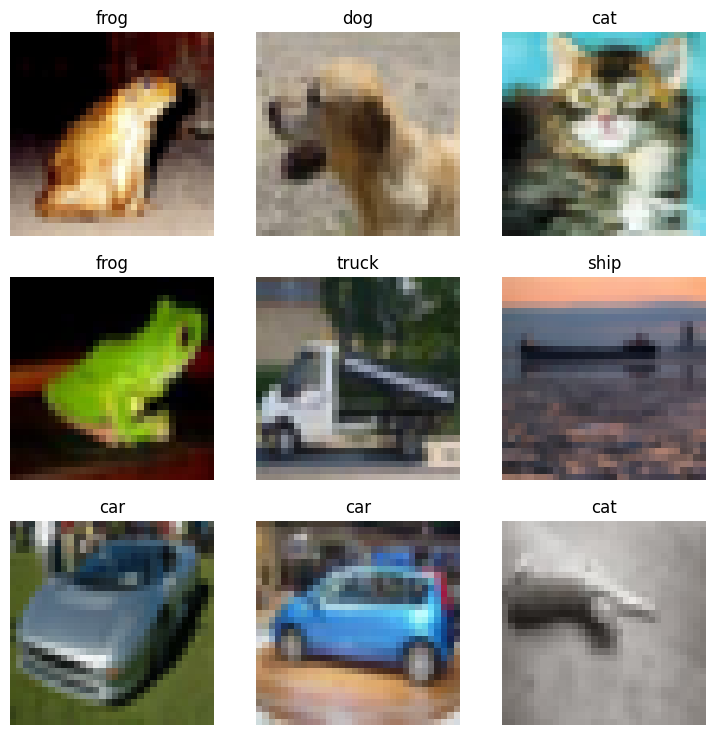

In [19]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create the appropriate transform, load/download CIFAR10 train and test datasets with transform
# ----------- <Your code> ---------------

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=transform)

# Print the shape of the image
image, label = train_dataset[0]
print(f"The dimension of the first picture is: {image.shape}")

# ----------- <End Your code> ---------------

# Define trainloader and testloader
# ----------- <Your code> ---------------

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# ----------- <End Your code> ---------------

# Code to display images
batch_idx, (images, targets) = next(enumerate(train_loader)) #fix!!!!!
fig, ax = plt.subplots(3,3,figsize = (9,9))
for i in range(3):
    for j in range(3):
        image = images[i*3+j].permute(1,2,0)
        image = image/2 + 0.5
        ax[i,j].imshow(image)
        ax[i,j].set_axis_off()
        ax[i,j].set_title(f'{classes[targets[i*3+j]]}')
fig.show()

### Task 2: Create CNN and train it
Set up a convolutional neural network and have your data trained on it. You have to decide all the details in your network, overall your neural network should meet the following standards to receive full credit:

*   You should not use more than three convolutional layers and three fully connected layers
*   Accuracy on the test dataset should be **above** 50%



In [20]:
# Create CNN network.
# ----------- <Your code> ---------------

class CNN4CIFAR10(nn.Module):  
    def __init__(self):
        super(CNN4CIFAR10, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input channels = 3, Output channels = 32
        self.bn1 = nn.BatchNorm2d(32)  
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  
        self.bn2 = nn.BatchNorm2d(64) 
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  
        self.bn3 = nn.BatchNorm2d(128)  
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # After conv3 output will be 128 channels of 4x4 feature maps
        self.bn_fc1 = nn.BatchNorm1d(256)  
        
        self.fc2 = nn.Linear(256, 128)  
        self.bn_fc2 = nn.BatchNorm1d(128) 
        
        self.fc3 = nn.Linear(128, 10)  

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))       
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(-1, 128 * 4 * 4)  # Flatten 128 channels of 4x4 feature maps
        
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = F.relu(self.bn_fc2(self.fc2(x)))    
        x = self.fc3(x)
        
        return x
    
    
# ----------- <End Your code> --------------- 

In [22]:
# Train your neural network here.
start = time.time()
max_epoch = 4
# ----------- <Your code> ---------------
# Define net

# Initialize model, optimizer, and criterion
net = CNN4CIFAR10().to(device)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


for epoch in range(max_epoch):
    train_loss = train(net, criterion, optimizer, train_loader, epoch)
    
    test_stat = test(net, criterion, test_loader, epoch)



# ----------- <End Your code> ---------------
output = test(net, criterion, test_loader, epoch)
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 0: [0/50000] Loss: 2.407
Epoch 0: [6208/50000] Loss: 1.272
Epoch 0: [12416/50000] Loss: 1.248
Epoch 0: [18624/50000] Loss: 1.064
Epoch 0: [24832/50000] Loss: 0.986
Epoch 0: [31040/50000] Loss: 0.935
Epoch 0: [37248/50000] Loss: 0.987
Epoch 0: [43456/50000] Loss: 0.865
Epoch 0: [49664/50000] Loss: 1.232
Test result on epoch 0: total sample: 10000, Avg loss: 0.870, Acc: 69.400%
Epoch 1: [0/50000] Loss: 0.782
Epoch 1: [6208/50000] Loss: 0.718
Epoch 1: [12416/50000] Loss: 0.947
Epoch 1: [18624/50000] Loss: 0.739
Epoch 1: [24832/50000] Loss: 0.579
Epoch 1: [31040/50000] Loss: 0.709
Epoch 1: [37248/50000] Loss: 0.634
Epoch 1: [43456/50000] Loss: 0.518
Epoch 1: [49664/50000] Loss: 0.437
Test result on epoch 1: total sample: 10000, Avg loss: 0.778, Acc: 72.320%
Epoch 2: [0/50000] Loss: 0.645
Epoch 2: [6208/50000] Loss: 0.703
Epoch 2: [12416/50000] Loss: 0.455
Epoch 2: [18624/50000] Loss: 0.432
Epoch 2: [24832/50000] Loss: 0.401
Epoch 2: [31040/50000] Loss: 0.556
Epoch 2: [37248/50000] Lo

### Task 3: Plot misclassified test images
Plot some misclassified images in your test dataset:

*   select three images that are **misclassified** by your neural network
*   label each images with true label and predicted label
*   use `detach().cpu()` when plotting images if the image is in gpu

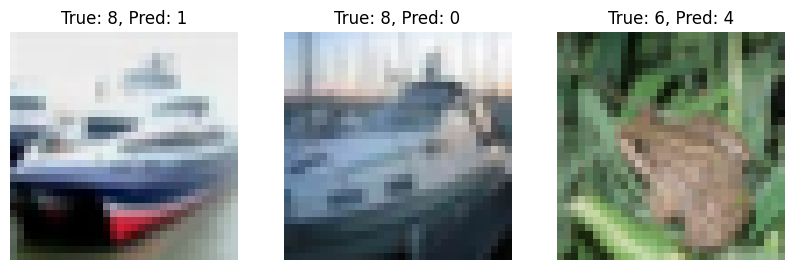

In [23]:
total_images = 3
predictions = output['prediction']
targets = torch.tensor(test_dataset.targets)
# ----------- <Your code> ---------------

# Find misclassified indices
misclassified_indices = (predictions != targets).nonzero(as_tuple=True)[0]

# select 3 misclassified images
misclassified_indices = misclassified_indices[:total_images]

fig, axs = plt.subplots(1, total_images, figsize=(10, 3))

for i, idx in enumerate(misclassified_indices):
    image, true_label = test_dataset[idx]
    
    # Detach and move image to CPU
    image = image.detach().cpu().numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    
    # Unnormalize the image (reverse the normalization) since we normalized with (0.5, 0.5, 0.5)
    image = image * 0.5 + 0.5  

    # Get the predicted label
    predicted_label = predictions[idx].item()

    # Plot the image
    axs[i].imshow(image)
    axs[i].axis('off')  
    axs[i].set_title(f'True: {true_label}, Pred: {predicted_label}')

plt.show()

# ----------- <End Your code> ---------------    

Questions (0 points): Are the mis-classified images also misleading to human eyes?

## Exercise 3: Transfer Learning (30 points)

In practice, people won't train an entire CNN from scratch, because it is relatively rare to have a dataset of sufficient size (or sufficient computational power). Instead, it is common to pretrain a CNN on a very large dataset and then use the CNN either as an initialization or a fixed feature extractor for the task of interest.

In this task, you will learn how to use a pretrained CNN for CIFAR-10 classification.

### Task1: Load pretrained model

`torchvision.models` (https://pytorch.org/vision/stable/models.html) contains definitions of models for addressing different tasks, including: image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection and video classification.

First, you should load the **pretrained** ResNet-18 that has already been trained on [ImageNet](https://www.image-net.org/) using `torchvision.models`. If you are interested in more details about Resnet-18, read this paper https://arxiv.org/pdf/1512.03385.pdf.

In [36]:
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device)

### Task2: Create data loaders for CIFAR-10

Then you need to create a modified dataset and dataloader for CIFAR-10. Importantly, the model you load has been trained on **ImageNet** and it expects inputs as mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be **at least** 224. So you need to preprocess the CIFAR-10 data to make sure it has a height and width of 224. Thus, you should add a transform when loading the CIFAR10 dataset (see [`torchvision.transforms.Resize`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize)).
This should be added appropriately to the `transform` you created in a previous task.

In [24]:
# Create your dataloader here
# ----------- <Your code> ---------------

transform = torchvision.transforms.Compose([
    transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=transform)

# Print the shape of the image
image, label = train_dataset[0]
print(f"The dimension of the first picture is: {image.shape}")

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# ----------- <End Your code> ---------------

Files already downloaded and verified
Files already downloaded and verified
The dimension of the first picture is: torch.Size([3, 224, 224])


### Task3: Classify test data on pretrained model

Use the model you load to classify the **test** CIFAR-10 data and print out the test accuracy.

Don't be surprised if the accuracy is bad!

In [27]:
# ----------- <Your code> ---------------

test_stat = test(resnet18, criterion, test_loader, epoch)

# ----------- <End Your code> ---------------

Test result on epoch 3: total sample: 10000, Avg loss: 11.708, Acc: 0.030%


### Task 4: Fine-tune (i.e., update) the pretrained model for CIFAR-10

Now try to improve the test accuracy. We offer several possible solutions:

(1) You can try to directly continue to train the model you load with the CIFAR-10 training data. 

(2) For efficiency, you can try to freeze part of the parameters of the loaded models. For example, you can first freeze all parameters by

```
for param in model.parameters():
    param.requires_grad = False
```
and then unfreeze the last few layers by setting `somelayer.requires_grad=True`.

You are also welcome to try any other approach you can think of.


**Note:** You must print out the test accuracy and to get full credits, the test accuracy should be at least **80%**.

In [32]:
# Directly train the whole model.
start = time.time()
#----------- <Your code> ---------------

# By default, param.requires_grad = True  
# for param in resnet18.parameters():
#     param.requires_grad = True  

# Modify the final fully connected layer to output 10 classes
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

net = resnet18.to(device)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(3):
    train_loss = train(net, criterion, optimizer, train_loader, epoch)
    
    # Evaluate the model after each epoch
    test_stat = test(net, criterion, test_loader, epoch)

# ----------- <End Your code> ---------------
test(resnet18, criterion, test_loader, epoch)
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 0: [0/50000] Loss: 2.385
Epoch 0: [6208/50000] Loss: 0.586
Epoch 0: [12416/50000] Loss: 0.805
Epoch 0: [18624/50000] Loss: 0.649
Epoch 0: [24832/50000] Loss: 0.605
Epoch 0: [31040/50000] Loss: 0.604
Epoch 0: [37248/50000] Loss: 0.653
Epoch 0: [43456/50000] Loss: 0.299
Epoch 0: [49664/50000] Loss: 0.455
Test result on epoch 0: total sample: 10000, Avg loss: 0.506, Acc: 83.490%
Epoch 1: [0/50000] Loss: 0.338
Epoch 1: [6208/50000] Loss: 0.293
Epoch 1: [12416/50000] Loss: 0.308
Epoch 1: [18624/50000] Loss: 0.364
Epoch 1: [24832/50000] Loss: 0.369
Epoch 1: [31040/50000] Loss: 0.300
Epoch 1: [37248/50000] Loss: 0.466
Epoch 1: [43456/50000] Loss: 0.292
Epoch 1: [49664/50000] Loss: 0.300
Test result on epoch 1: total sample: 10000, Avg loss: 0.352, Acc: 88.140%
Epoch 2: [0/50000] Loss: 0.262
Epoch 2: [6208/50000] Loss: 0.201
Epoch 2: [12416/50000] Loss: 0.424
Epoch 2: [18624/50000] Loss: 0.178
Epoch 2: [24832/50000] Loss: 0.294
Epoch 2: [31040/50000] Loss: 0.174
Epoch 2: [37248/50000] Lo

In [35]:
# Load another resnet18 instance, only unfreeze the outer layers. 
# ----------- <Your code> ---------------

resnet18 = models.resnet18(weights=True)

# Freeze all layers, we don't want to train them
for param in resnet18.parameters():
    param.requires_grad = False  

# Modify the final fully connected layer to output 10 classes
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10) # This will replaced with a new one

# Unfreeze the final fully connected layer
for param in resnet18.fc.parameters():
    param.requires_grad = True

# ----------- <End Your code> ---------------

In [34]:
# Train the model!!
start = time.time()
# ----------- <Your code> ---------------

net = resnet18.to(device)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

for epoch in range(3):
    train_loss = train(net, criterion, optimizer, train_loader, epoch)
    
    # Evaluate the model after each epoch
    test_stat = test(net, criterion, test_loader, epoch)
    
# ----------- <End Your code> ---------------
test(resnet18, criterion, test_loader)
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 0: [0/50000] Loss: 2.385
Epoch 0: [6208/50000] Loss: 0.966
Epoch 0: [12416/50000] Loss: 0.712
Epoch 0: [18624/50000] Loss: 0.807
Epoch 0: [24832/50000] Loss: 0.592
Epoch 0: [31040/50000] Loss: 0.696
Epoch 0: [37248/50000] Loss: 0.613
Epoch 0: [43456/50000] Loss: 0.607
Epoch 0: [49664/50000] Loss: 0.846
Test result on epoch 0: total sample: 10000, Avg loss: 0.611, Acc: 79.220%
Epoch 1: [0/50000] Loss: 0.466
Epoch 1: [6208/50000] Loss: 0.581
Epoch 1: [12416/50000] Loss: 0.517
Epoch 1: [18624/50000] Loss: 0.625
Epoch 1: [24832/50000] Loss: 0.616
Epoch 1: [31040/50000] Loss: 0.802
Epoch 1: [37248/50000] Loss: 0.561
Epoch 1: [43456/50000] Loss: 0.758
Epoch 1: [49664/50000] Loss: 0.353
Test result on epoch 1: total sample: 10000, Avg loss: 0.605, Acc: 78.970%
Epoch 2: [0/50000] Loss: 0.758
Epoch 2: [6208/50000] Loss: 0.388
Epoch 2: [12416/50000] Loss: 0.575
Epoch 2: [18624/50000] Loss: 0.508
Epoch 2: [24832/50000] Loss: 0.688
Epoch 2: [31040/50000] Loss: 0.449
Epoch 2: [37248/50000] Lo